# Neighborhood sizes in 2D and 3D

In [1]:
## Imports
import squidpy as sq
import anndata as ad ## using anndata until sq is spatialdata-compatible
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.stats import linregress

In [2]:
## Load 3D centroids & phenotype information
centroids_3D = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_3D.csv')
phenotypes = pd.read_csv('../../data/Kuett_2022/MainHer2BreastCancerModel/model201710_cluster_labels_phenograph_recoded.csv')

adata3 = ad.AnnData(obs=pd.merge(centroids_3D['id'], phenotypes[['id','ct_broad']], on='id', how='left').rename(columns={'ct_broad':'phenotype'}).drop(columns='id'),
                    obsm={'spatial': centroids_3D[['x', 'y', 'z']].values})
adata3

/home/gesa/.py_venv/squidpy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 108486 × 0
    obs: 'phenotype'
    obsm: 'spatial'

In [3]:
## Choose 2D files for comparison
# We want an approx. equivalent number of cells in 2D and 3D
# such that variability in 2D is not due to fewer cells
fn_2D = "../../data/Kuett_2022/MainHer2BreastCancerModel/measured_mask_centroids_2D/measured_mask_centroids_2D_*.csv"

files_2D = np.array(glob.glob(fn_2D)) ## list of files (full path)

## Get mean n_cells in 2D
n_cells_2D = np.empty(len(files_2D), dtype=int)
for i, file in enumerate(files_2D):
    with open(file) as f:
        n_cells_2D[i] = sum(1 for line in f)-1 ## without header
n_slices = int(np.round(centroids_3D.shape[0] / n_cells_2D.mean()))

## Choose files at random
rng = np.random.default_rng(42) 
rand = rng.choice(len(files_2D), size=n_slices, replace=False)
files_2D_selection = files_2D[rand]
print(f"Selected {n_slices} files")
print(f"n_cells 2D: {n_cells_2D[rand].sum()}; 3D: {centroids_3D.shape[0]}")

Selected 43 files
n_cells 2D: 107374; 3D: 108486


In [4]:
## Load 2D data
# squidpy currently requires one AnnData object per image
centroids_2D = pd.concat([pd.read_csv(file) for file in files_2D_selection])

phenotypes.set_index('id', inplace=True)
adata2 = [ ad.AnnData(obs = pd.DataFrame( {'phenotype': phenotypes.loc[ centroids_2D.loc[ centroids_2D['z'] == i, 'id'], 'ct_broad' ].values},
                                          index=np.arange((centroids_2D['z'] == i).sum()).astype(str) ),
                      obsm = {'spatial': centroids_2D.loc[ centroids_2D['z'] == i, ['x', 'y']].values})
                      for i in np.unique(centroids_2D['z']) ]
phenotypes.reset_index(drop=False, inplace=True)
len(adata2)

43

2D median: 6.8 μm
3D median: 6.48 μm


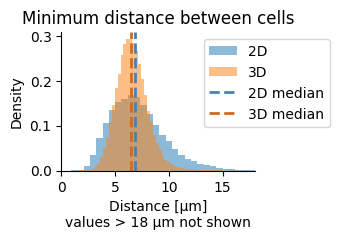

In [5]:
## Min dist between cells
def min_dist_cells(adata):
    tree = cKDTree(adata.obsm['spatial'])
    dists = tree.query(adata.obsm['spatial'], k=2)[0][:,1]
    return dists
dists_2D = [ min_dist_cells(adata) for adata in adata2 ]
dists_3D = min_dist_cells(adata3)
dists_2D = np.concatenate(dists_2D)

median_2D = np.median(dists_2D)
median_3D = np.median(dists_3D)

# Plot
print(f"2D median: {median_2D:.2} μm\n3D median: {median_3D:.2f} μm")
plt.subplots(figsize=(2.5,1.8))
plt.hist(dists_2D, bins=100, alpha=0.5, density=True, label='2D')
plt.hist(dists_3D, bins=100, alpha=0.5, density=True, label='3D')
plt.axvline(median_2D, color='steelblue', linestyle='dashed', linewidth=2, label='2D median')
plt.axvline(median_3D, color='chocolate', linestyle='dashed', linewidth=2, label='3D median')
plt.xlim(0, 18)
plt.title('Minimum distance between cells')
plt.xlabel('Distance [μm]\nvalues > 18 μm not shown')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(.7, 1), loc='upper left')
sns.despine(top=True, right=True)

#plt.savefig('../../figures/nbh_size_minimum_distance_between_cells.svg', bbox_inches='tight')
plt.show()

In [6]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(dists_2D, dists_3D, alternative='greater')
print(f"p-value: {p:.2e}")

p-value: 0.00e+00


In [ ]:
## Get number of neighbors for a range of radii
def get_knns(adata, radius):
    # Build spatial graph
    connectivities, _ = sq.gr.spatial_neighbors(adata, spatial_key="spatial", coord_type='generic',
                                                delaunay=False, radius=radius, copy=True)
    # Get number of neighbors per cell
    nneighbors = np.array(connectivities.sum(1)).squeeze()
    return nneighbors

radii = np.arange(10, 51, 10)
knns = pd.DataFrame(columns=['radius','mean_2','sdev_2', 'mean_3', 'sdev_3'])
knns['radius'] = radii
for radius in radii:
    radius = int(radius) # type conversion for squidpy function
    # in 2D
    nn2 = get_knns(adata2[0], radius)
    for adata in adata2[1:]:
        nn2 = np.append(nn2, get_knns(adata, radius))
    knns.loc[knns['radius'] == radius, ['mean_2', 'sdev_2']] = [nn2.mean(), nn2.std()]
    # in 3D
    nn3 = get_knns(adata3, radius)
    knns.loc[knns['radius'] == radius, ['mean_3', 'sdev_3']] = [nn3.mean(), nn3.std()]
knns

,radius,mean_2,sdev_2,mean_3,sdev_3
0,10,1.94671,1.246079,4.428498,2.086939
1,20,9.858066,3.180636,38.229357,11.110664
2,30,22.289325,6.293464,124.958704,35.061542
3,40,39.134818,10.546328,286.74216,82.085327
4,50,60.213851,16.028763,542.962631,160.204455


In [ ]:
## Sanity check
radius = 10
connectivities, distances = sq.gr.spatial_neighbors(adata3, spatial_key="spatial", coord_type='generic',
                                                    delaunay=False, radius=radius, copy=True)
assert distances.max() <= radius # no distance > radius
pt0 = adata3.obsm['spatial'][0]
pt1 = adata3.obsm['spatial'][distances.indices[0]] # a neighbor of pt0
assert distances.data[0] == np.sqrt(((pt0 - pt1)**2).sum()) # distance calc. by squidpy == calc. by hand

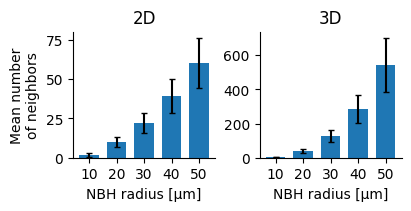

In [ ]:
## Plot
fig, ax = plt.subplots(1, 2, figsize=(4,2), layout='constrained')
for i in [2, 3]:
        ax[i-2].bar(knns['radius'], knns[f'mean_{i}'], yerr=knns[f'sdev_{i}'], width=7, capsize=2)
        ax[i-2].set_xticks(knns['radius'])
        ax[i-2].set_title(f'{i}D')
        ax[i-2].set_xlabel('NBH radius [μm]')
ax[0].set_ylabel('Mean number\nof neighbors')
sns.despine(top=True, right=True)

#plt.savefig('../../figures/nbh_size_knn_2D_3D_barplot.svg', bbox_inches='tight')
plt.show()

y = 1.40 x + 0.51
ρ = 1.00, p = 0.00


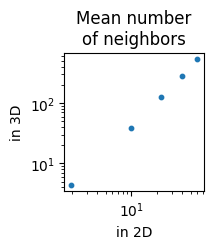

In [9]:
## Find linear relationship between variables
slope, intercept, r_value, p_value, std_err = linregress(np.log(knns['mean_2'].values.astype(float)), np.log([knns['mean_3'].values.astype(float)]))
print(f'y = {slope:.2f} x + {intercept:.2f}\nρ = {r_value:.2f}, p = {p_value:.2f}')

plt.subplots(figsize=(1.8,1.8))
plt.scatter(knns['mean_2'], knns['mean_3'], s=10)
plt.xscale('log')
plt.yscale('log')
plt.title('Mean number\nof neighbors')
plt.xlabel('in 2D')
plt.ylabel('in 3D')
plt.show()

Let's check whether the number of neighbors makes sense geometrically. For simplicity, we use the assumption that the cells are approximately equally distributed in space, such that the number of cells in an area/volume can be used as a unit of area/volume itself. We then expect the following relationship:
- area of a circle: $A = π r^2$
- volume of a sphere: $V = 4/3 π r^3$
- expected relationship: $A / V = knn_{2D} / knn_{3D} = 3/(4r)$

y = 7.17 x + 0.01
ρ = 1.00, p = 0.00


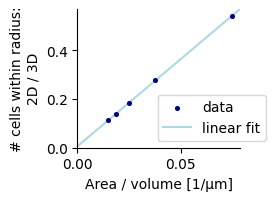

In [ ]:
x = np.array( 3 / ( 4 * knns['radius'] ) ).astype(float)
y = np.array( (knns['mean_2']+1) / (knns['mean_3']+1) ).astype(float) # +1 to add index cell

slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(f'y = {slope:.2f} x + {intercept:.2f}\nρ = {r_value:.2f}, p = {p_value:.2f}')

plt.subplots(figsize=(2.1,1.8))
plt.scatter(x, y, label='data', s=7, zorder=2.5, color='darkblue')
plt.axline((0, intercept), slope=slope, label=f'linear fit', color='lightblue')
plt.xlim(0)
plt.ylim(0)
plt.xlabel('Area / volume [1/μm]')
plt.ylabel('# cells within radius:\n2D / 3D')
plt.legend(bbox_to_anchor=(1.2,0), loc='lower right')
sns.despine(top=True, right=True)

#plt.savefig('../../figures/nbh_size_knn_2D_3D_geom.svg', bbox_inches='tight')
plt.show() 

2D → 3D neighbors:
5 →  16
10 →  39
20 → 107
50 → 412


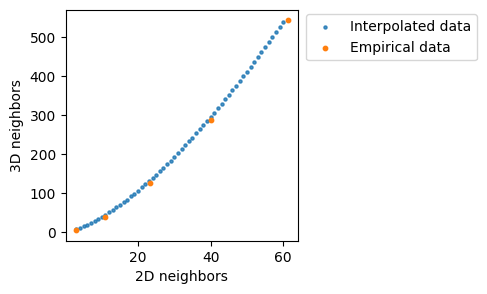

In [ ]:
# Create a table to relate knn values between 2D and 3D
outfile = '../../data/nbh_size_knn.csv'

# Interpolate
# 2D and 3D values grow exponentially, but at different rates
knns_2D = np.arange(3,61)
knns_3D = np.exp(
    np.interp(np.log( knns_2D ), 
    np.log( knns['mean_2'].astype(float) ),
    np.log( knns['mean_3'].astype(float) ) ) )
knns_interp = pd.DataFrame({'knn_2D': knns_2D, 'knn_3D': np.round(knns_3D).astype(int)})

# Save to file
knns_interp.to_csv(outfile, sep=",", index=False)

# Sample values
sample_knns = [5,10,20,50]
print('2D → 3D neighbors:')
for knn in sample_knns:
    print(f"{knn} → {knns_interp.loc[knns_interp['knn_2D'] == knn, 'knn_3D'].values[0]:3d}")

# Plot (sanity check)
plt.subplots(figsize=(3,3))
plt.scatter(knns_interp['knn_2D'], knns_interp['knn_3D'],
            s=5, alpha=.8, label='Interpolated data')
plt.scatter((knns['mean_2']+1).values.astype(float),
            (knns['mean_3']+1).values.astype(float),
            s=10, label='Empirical data')
plt.legend(bbox_to_anchor=(1.8,1.01), loc='upper right')
plt.xlabel('2D neighbors')
plt.ylabel('3D neighbors')
plt.show()

In [ ]:
## Number of neighbors using Delaunay triangulation
def get_knns_delaunay(adata):
    connectivities, _ = sq.gr.spatial_neighbors(adata, spatial_key="spatial", coord_type='generic',
                                                delaunay=True, copy=True)
    nneighbors = np.array(connectivities.sum(1)).squeeze()
    return nneighbors
# in 2D
nn2 = get_knns_delaunay(adata2[0])
for adata in adata2[1:]:
    nn2 = np.append(nn2, get_knns_delaunay(adata))
# in 3D
nn3 = get_knns_delaunay(adata3)

median 2D: 6, 3D: 15


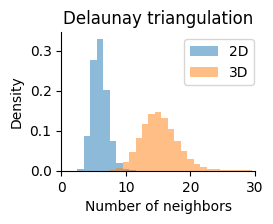

In [15]:
## Plot
print(f'median 2D: {int(np.median(nn2))}, 3D: {int(np.median(nn3))}')

plt.subplots(figsize=(2.5,1.8))
bins = np.arange(0, max(nn2.max(), nn3.max())+1, 1)-.5
plt.hist(nn2, bins=bins, density=True, alpha=0.5, label='2D')
plt.hist(nn3, bins=bins, density=True, alpha=0.5, label='3D')
plt.title('Delaunay triangulation')
plt.xlabel('Number of neighbors')
plt.ylabel('Density')
plt.xlim(0,30)
sns.despine(top=True, right=True)
plt.legend(bbox_to_anchor=(.6, 1), loc='upper left')

#plt.savefig('../../figures/nbh_size_delaunay_2D_3D.svg', bbox_inches='tight')
plt.show()

In [ ]:
## Save environment specs
!pip freeze > ../../environment/nbh_size.txt